In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt; 
%matplotlib inline
from shapely.geometry import Point, Polygon, box

## Area

In [124]:
from shapely.geometry import box
import geopandas as gpd

xmin=0; ymin=0; xmax=1; ymax=1
rect = box(xmin, ymin, xmax, ymax)
area1 = gpd.GeoDataFrame({'area_name':['area1'],
                          'visibility': [0.90],
                          'geometry': rect}, 
                         geometry='geometry'
                        )
area1

,area_name,visibility,geometry
0,area1,0.9,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))"


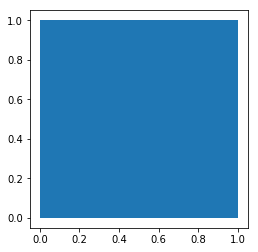

In [125]:
area1.plot()

In [154]:
1200/300

4.0

## Coverage

### Transects

maximize for the longest single transect?
maximize for total survey area? need to buffer before calculating this

In [126]:
def make_transects(transect_interval, sweep_width, angle_degrees, area_gdf):
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import LineString

    xmin = area_gdf.bounds.minx.min()
    xmax = area_gdf.bounds.maxx.max()
    ymin = area_gdf.bounds.miny.min()
    ymax = area_gdf.bounds.maxy.max()

    h = ymax-ymin

    def standard(temp_angle):
        theta = np.radians(temp_angle)
        horiz_shift = (1/np.cos(theta)) * transect_interval
        top_start = xmin
        
        # calculate bottom starting point
        a = (1/np.tan(theta)) * transect_interval
        b = h - a
        bottom_start_shift = np.tan(theta) * b
        bottom_start = xmin - bottom_start_shift
        
        n_transects = int((xmax - bottom_start) / horiz_shift)
        
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects
    
    def special(horiz_shift, top_start, bottom_start):
        n_transects = int((xmax - bottom_start) / horiz_shift)
    
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects


    if 0 < angle_degrees < 90:
        top_vals, bottom_vals, n_transects = standard(angle_degrees)
        
    elif 90 < angle_degrees < 180:
        supplement = 180 - angle_degrees
        bottom_vals, top_vals, n_transects = standard(supplement)
        
    elif angle_degrees in [0, 180]:
        horiz_shift = transect_interval
        top_start = xmin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    elif angle_degrees == 90:
        horiz_shift = transect_interval
        top_start = ymin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    top_coords = list(zip(top_vals, np.full_like(top_vals, fill_value=ymax)))
    bottom_coords = list(zip(bottom_vals, np.full_like(bottom_vals, fill_value=ymin)))

    lines_gs = gpd.GeoSeries([LineString(coord_pair) for coord_pair in zip(top_coords, bottom_coords)])
    lines_gdf = gpd.GeoDataFrame({'length': np.arange(0, n_transects),
                                  'geometry': lines_gs
                                 }, geometry='geometry')
    
    # clip lines by bounding box
    poly = area1.geometry.unary_union
    spatial_index = lines_gdf.sindex
    bbox = poly.bounds
    sidx = list(spatial_index.intersection(bbox))
    lines_sub = lines_gdf.iloc[sidx]
    clipped = lines_sub.copy()
    clipped['geometry'] = lines_sub.intersection(poly)
    lines_clipped = clipped[clipped.geometry.notnull()]
    
    
    transects_buffer = lines_clipped.buffer(sweep_width)  # buffer transects
    buffer_gdf = gpd.GeoDataFrame({'angle_deg':[angle_degrees] * n_transects,
                                   'length': lines_clipped.length,
                                   'geometry': transects_buffer}, 
                                   geometry='geometry')

    transects = gpd.overlay(buffer_gdf, area_gdf, how='intersection')
    transects['area'] = transects.area
    
    return transects

In [127]:
def compare_transect_angles(transect_interval, sweep_width, area_gdf):
    import pandas as pd
    
    df_list=[]
    for angle in range(0, 180, 5):
        df = make_transects(transect_interval, sweep_width, angle, area_gdf)
        df_list.append(df)
    
    angle_df = pd.concat(df_list)
    
#     return angle_df
    return angle_df.groupby('angle_deg')['area'].sum()

In [128]:
compare_transect_angles(0.1, 0.02, area1)

angle_deg
0      0.360000
5      0.360028
10     0.390733
15     0.385825
20     0.383566
25     0.383672
30     0.381247
35     0.380110
40     0.378783
45     0.379053
50     0.379179
55     0.379337
60     0.381065
65     0.381619
70     0.384788
75     0.384342
80     0.388637
85     0.393532
90     0.360000
95     0.393532
100    0.388637
105    0.384342
110    0.384788
115    0.381619
120    0.381065
125    0.379337
130    0.379179
135    0.379053
140    0.378783
145    0.380110
150    0.381247
155    0.383672
160    0.383566
165    0.385825
170    0.390733
175    0.360028
Name: area, dtype: float64

In [144]:
coverage = make_transects(0.1, 0.03, 85, area1)

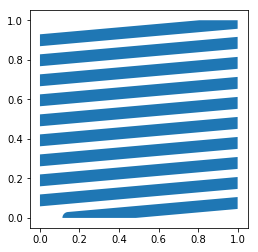

In [145]:
c = coverage.plot()

## Assemblage

### Layer 1

In [146]:
from numpy.random import random
from shapely.geometry import Point
import geopandas as gpd

n = 5
xrange=(0, 1); yrange=(0, 1)

xs = (random(n) * (xrange[1] - xrange[0])) + xrange[0]
ys = (random(n) * (yrange[1] - yrange[0])) + yrange[0]
gds = gpd.GeoSeries([Point(xy) for xy in zip(xs, ys)])

ceramics = gpd.GeoDataFrame({'layer_name': ['ceramics'] * n,
                           'fid': [f'ceramics_{i}' for i in range(n)],
                           'time_penalty': [0.1] * n,
                           'ideal_obs_rate': [0.95] * n,
                           'geometry': gds},
                          geometry = 'geometry'
                         )
ceramics

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,0.1,0.95,POINT (0.2553131479379528 0.2999713198255038)
1,ceramics,ceramics_1,0.1,0.95,POINT (0.7165691920061654 0.1829924683878686)
2,ceramics,ceramics_2,0.1,0.95,POINT (0.9333342582926215 0.249550047925745)
3,ceramics,ceramics_3,0.1,0.95,POINT (0.3617050089889319 0.1500994491246844)
4,ceramics,ceramics_4,0.1,0.95,POINT (0.1638510785254986 0.2337651769897545)


### Layer 2

In [147]:
n = 20
xrange=(0, 1); yrange=(0, 1)

xs = (random(n) * (xrange[1] - xrange[0])) + xrange[0]
ys = (random(n) * (yrange[1] - yrange[0])) + yrange[0]
gds = gpd.GeoSeries([Point(xy) for xy in zip(xs, ys)])

lithics = gpd.GeoDataFrame({'layer_name': ['lithics'] * n,
                           'fid': [f'lithics_{i}' for i in range(n)],
                           'time_penalty': [0.15] * n,
                           'ideal_obs_rate': [0.80] * n,
                           'geometry': gds},
                          geometry = 'geometry'
                         )
lithics

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,lithics,lithics_0,0.15,0.8,POINT (0.4818239249348231 0.6077473325191283)
1,lithics,lithics_1,0.15,0.8,POINT (0.7691409944946874 0.4290152382315694)
2,lithics,lithics_2,0.15,0.8,POINT (0.01115511533667835 0.8744513882465722)
3,lithics,lithics_3,0.15,0.8,POINT (0.464199007099982 0.8706180584234262)
4,lithics,lithics_4,0.15,0.8,POINT (0.7482088859802514 0.3065574471582014)
5,lithics,lithics_5,0.15,0.8,POINT (0.4716860247985635 0.5656742936454831)
6,lithics,lithics_6,0.15,0.8,POINT (0.4860719684385395 0.8748720596630408)
7,lithics,lithics_7,0.15,0.8,POINT (0.4982131722039236 0.1145040339390984)
8,lithics,lithics_8,0.15,0.8,POINT (0.1006278575337749 0.4596771034158917)
9,lithics,lithics_9,0.15,0.8,POINT (0.475881235219391 0.3261797507401051)


In [148]:
assemblage = pd.concat([ceramics, lithics], ignore_index=True)
assemblage

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,0.10,0.95,POINT (0.2553131479379528 0.2999713198255038)
1,ceramics,ceramics_1,0.10,0.95,POINT (0.7165691920061654 0.1829924683878686)
2,ceramics,ceramics_2,0.10,0.95,POINT (0.9333342582926215 0.249550047925745)
3,ceramics,ceramics_3,0.10,0.95,POINT (0.3617050089889319 0.1500994491246844)
4,ceramics,ceramics_4,0.10,0.95,POINT (0.1638510785254986 0.2337651769897545)
5,lithics,lithics_0,0.15,0.80,POINT (0.4818239249348231 0.6077473325191283)
6,lithics,lithics_1,0.15,0.80,POINT (0.7691409944946874 0.4290152382315694)
7,lithics,lithics_2,0.15,0.80,POINT (0.01115511533667835 0.8744513882465722)
8,lithics,lithics_3,0.15,0.80,POINT (0.464199007099982 0.8706180584234262)
9,lithics,lithics_4,0.15,0.80,POINT (0.7482088859802514 0.3065574471582014)


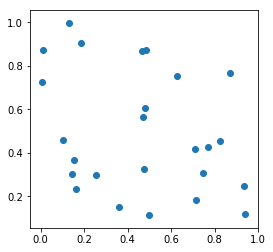

In [149]:
assemblage.plot()

## Team

In [150]:
import pandas as pd

team = pd.DataFrame({'surveyor_type': ['pi', 'grad', 'undergrad', 'undergrad', 'undergrad'],
                     'skill': [1.0, 0.95, 0.85, 0.85, 0.85],
                     'speed_penalty': [0.0, 0.0, 0.2, 0.2, 0.2]
                    })

for stype in team['surveyor_type'].unique():
    stype_df = team.loc[team['surveyor_type']==stype, :]
    team.loc[stype_df.index, 'sid'] = [i for i in range(stype_df.shape[0])]

team['sid'] = team.apply(lambda x: x['surveyor_type'] + '_' + str(int(x['sid'])), axis=1)
team = team.loc[:, ['sid', 'surveyor_type', 'skill', 'speed_penalty']]
team

,sid,surveyor_type,skill,speed_penalty
0,pi_0,pi,1.00,0.0
1,grad_0,grad,0.95,0.0
2,undergrad_0,undergrad,0.85,0.2
3,undergrad_1,undergrad,0.85,0.2
4,undergrad_2,undergrad,0.85,0.2


In [151]:
team

,sid,surveyor_type,skill,speed_penalty
0,pi_0,pi,1.00,0.0
1,grad_0,grad,0.95,0.0
2,undergrad_0,undergrad,0.85,0.2
3,undergrad_1,undergrad,0.85,0.2
4,undergrad_2,undergrad,0.85,0.2


## Putting it all together

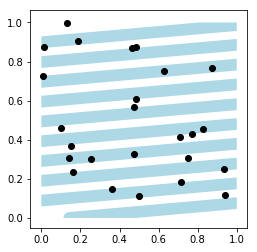

In [152]:
assemblage.plot(ax=coverage.plot(color='lightblue'), color='black')

In [ ]:
# allocate surveyors to transects

In [ ]:
# find which artifacts intersect which transect

In [ ]:
# apply visibility factor

In [ ]:
# apply ideal_obs_rate

In [ ]:
# apply surveyor skill

In [ ]:
# add time based on surveyor speed

In [ ]:
# add time penalty for finds to transect

In [ ]:
# compare assemblage to finds